# Проект "Дашборд конверсий"

## Шаг 1 Выгрузим необходимые библиотеки

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
import plotly.express as px
from dotenv import load_dotenv
import os
import json

## Шаг 2 Выгрузка по API 01/03/2023-01/09/2023

In [2]:
# Загрузка переменных окружения
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN', '2023-03-01')
DATE_END = os.getenv('DATE_END', '2023-04-02')
API_URL = os.getenv('API_URL', 'https://data-charts-api.hexlet.app')

In [6]:
# Запрос данных по визитам
visits_json = requests.get(f"{API_URL}/visits?begin={DATE_BEGIN}&end{DATE_END}")
#visits_json = requests.get("https://data-charts-api.hexlet.app/visits?begin=2023-03-01&end2023-04-02")
visits_data = visits_json.json()
df_visits = pd.DataFrame(visits_data)
df_visits.head(2000000)

,visit_id,platform,user_agent,datetime
0,1de9ea66-70d3-4a1f-8735-df5ef7697fb9,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01T10:36:22
1,f149f542-e935-4870-9734-6b4501eaf614,web,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,2023-03-01T06:25:00
2,08f0ebd4-950c-4dd9-8e97-b5bdf073eed1,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,2023-03-01T10:26:13
3,19322fed-157c-49c6-b16e-2d5cabeb9592,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,2023-03-01T12:33:06
4,04762a22-3c9f-40c9-9ac9-6628c4381836,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01T01:38:35
...,...,...,...,...
263454,6d2e2f5b-970b-4dfe-8f57-25711a5b2a5d,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,2023-08-29T10:43:29
263455,1d91535e-d984-4f76-bbaa-c14c0fd4f2e2,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-08-29T19:29:16
263456,f2496721-7126-430d-976e-777a6cdccb4f,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-08-29T12:51:11
263457,f2496721-7126-430d-976e-777a6cdccb4f,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-08-29T21:45:08


In [7]:
# Запрос данных по регистрациям
registrations_json = requests.get(f"{API_URL}/registrations?begin={DATE_BEGIN}&end{DATE_END}")
#registrations_json = requests.get("https://data-charts-api.hexlet.app/registrations?begin=2023-03-01&end=2023-04-02")
registrations_data = registrations_json.json()
df_registrations = pd.DataFrame(registrations_data)
df_registrations.head()

,datetime,user_id,email,platform,registration_type
0,2023-03-01T07:40:13,2e0f6bb8-b029-4f45-a786-2b53990d37f1,ebyrd@example.org,web,google
1,2023-03-01T13:14:00,f007f97c-9d8b-48b5-af08-119bb8f6d9b6,knightgerald@example.org,web,email
2,2023-03-01T03:05:50,24ff46ae-32b3-4a74-8f27-7cf0b8f32f15,cherylthompson@example.com,web,apple
3,2023-03-01T00:04:47,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60,halldavid@example.org,web,email
4,2023-03-01T18:31:52,27f875fc-f8ce-4aeb-8722-0ecb283d0760,denise86@example.net,web,google


## Шаг 3 - Расчет метрик

In [9]:
# Работа с визитами
def clean_visits(df_visits):
    df_visits_filtered = df_visits.copy()
    df_visits_filtered['visit_dt'] = pd.to_datetime(df_visits_filtered['datetime'])
    df_visits_filtered = df_visits_filtered.sort_values(by=['visit_id', 'visit_dt']).drop_duplicates(subset='visit_id', keep='last')
    df_visits_filtered = df_visits_filtered[~df_visits_filtered['user_agent'].str.contains('bot')]
    df_visits_filtered['platform'] = df_visits_filtered['platform'].str.strip("`")
    df_visits_filtered['date_group'] = df_visits_filtered['visit_dt'].dt.to_period('D').dt.start_time.dt.date
    df_visits_filtered = df_visits_filtered.groupby(['date_group', 'platform']).size().reset_index(name='visits')
    return df_visits_filtered

cleaned_visits = clean_visits(df_visits)
cleaned_visits.head(10)

,date_group,platform,visits
0,2023-03-01,android,75
1,2023-03-01,ios,22
2,2023-03-01,web,279
3,2023-03-02,android,67
4,2023-03-02,ios,31
5,2023-03-02,web,515
6,2023-03-03,android,26
7,2023-03-03,ios,40
8,2023-03-03,web,617
9,2023-03-04,android,94


In [10]:
# Работа с регистрациями
def clean_registrations(df_registrations):
    df_registrations_filtered = df_registrations.drop_duplicates()
    df_registrations_filtered['platform'] = df_registrations_filtered['platform'].fillna('web')
    df_registrations_filtered['registration_dt'] = pd.to_datetime(df_registrations_filtered['datetime'])
    df_registrations_filtered['date_group'] = df_registrations_filtered['registration_dt'].dt.to_period('D').dt.start_time.dt.date
    df_registrations_filtered = df_registrations_filtered.groupby(['date_group', 'platform']).size().reset_index(name='registrations')
    return df_registrations_filtered

cleaned_registrations = clean_registrations(df_registrations)
cleaned_registrations.head(15)

,date_group,platform,registrations
0,2023-03-01,android,61
1,2023-03-01,ios,18
2,2023-03-01,web,8
3,2023-03-02,android,59
4,2023-03-02,ios,24
5,2023-03-02,web,23
6,2023-03-03,android,22
7,2023-03-03,ios,34
8,2023-03-03,web,51
9,2023-03-04,android,77


In [53]:
# Расчет конверсии
def visits_registrations_merged(cleaned_visits, cleaned_registrations):
    merged_df = pd.merge(cleaned_visits, cleaned_registrations, on=['date_group', 'platform'])
    merged_df['conversion'] = (cleaned_registrations['registrations'] / cleaned_visits['visits']) * 100
    merged_df.to_json('conversion.json')
    return merged_df

visits_regs_conv = visits_registrations_merged(cleaned_visits, cleaned_registrations)
visits_regs_conv.head(10)

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355
5,2023-03-02,web,515,23,4.466019
6,2023-03-03,android,26,22,84.615385
7,2023-03-03,ios,40,34,85.000000
8,2023-03-03,web,617,51,8.265802
9,2023-03-04,android,94,77,81.914894


## Шаг 4 Добавление рекламы

In [54]:
# Очистка и подготовка файла рекламных кампаний
def clean_ads(df_ads):
    df_ads = df_ads.drop_duplicates()
    df_ads['date'] = pd.to_datetime(df_ads['date'], format='mixed')
    df_ads['date'] = df_ads['date'].dt.to_period('D').dt.start_time.dt.date
    df_ads = df_ads.rename(columns={'date': 'date_group'})
    df_ads['utm_campaign'] = df_ads['utm_campaign'].fillna('none')
    df_ads['cost'] = df_ads['cost'].fillna('0')
    return df_ads

df_ads = pd.read_csv('./ads.csv')
cleaned_ads = clean_ads(df_ads)
cleaned_ads.head(10)

,date_group,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01,google,cpc,advanced_algorithms_series,212
1,2023-03-02,google,cpc,advanced_algorithms_series,252
2,2023-03-03,google,cpc,advanced_algorithms_series,202
3,2023-03-04,google,cpc,advanced_algorithms_series,223
4,2023-03-05,google,cpc,advanced_algorithms_series,265
5,2023-03-06,google,cpc,advanced_algorithms_series,108
6,2023-03-07,google,cpc,advanced_algorithms_series,165
7,2023-03-08,google,cpc,advanced_algorithms_series,155
8,2023-03-09,google,cpc,advanced_algorithms_series,124
9,2023-03-10,google,cpc,advanced_algorithms_series,276


In [21]:
# Агрегация рекламных данных по дате и кампании
def ads_agr(df_ads, date1, date2):
    date1 = pd.to_datetime(date1).date()
    date2 = pd.to_datetime(date2).date()
    ads_filtred = df_ads[(df_ads['date_group'] >= date1) & (df_ads['date_group'] <= date2)]
    ads_agd = ads_filtred.groupby(['date_group', 'utm_campaign']).sum(['cost']).reset_index()
    return ads_agd

ads_agr = ads_agr(cleaned_ads, DATE_BEGIN, DATE_END)
ads_agr.head(10)

,date_group,utm_campaign,cost
0,2023-03-01,advanced_algorithms_series,212
1,2023-03-02,advanced_algorithms_series,252
2,2023-03-03,advanced_algorithms_series,202
3,2023-03-04,advanced_algorithms_series,223
4,2023-03-05,advanced_algorithms_series,265
5,2023-03-06,advanced_algorithms_series,108
6,2023-03-07,advanced_algorithms_series,165
7,2023-03-08,advanced_algorithms_series,155
8,2023-03-09,advanced_algorithms_series,124
9,2023-03-10,advanced_algorithms_series,276


In [55]:
# Объединение визитов, регистраций и рекламных данных
def merged_ads_conv(vis_reg_conv, cleaned_ads):
    convers_ads = pd.merge(
        vis_reg_conv, cleaned_ads, 
        left_on='date_group', 
        right_on='date_group',
        how='left')
    convers_ads.loc[convers_ads['utm_campaign'].isnull(), 'utm_campaign'] = 'none'
    convers_ads = convers_ads[['date_group', 'platform', 'visits', 'registrations', 'conversion', 'cost', 'utm_campaign']]
    convers_ads.to_json('ads.json')
    return convers_ads

convers_ads = merged_ads_conv(visits_regs_conv, cleaned_ads)
convers_ads.head(20)

,date_group,platform,visits,registrations,conversion,cost,utm_campaign
0,2023-03-01,android,75,61,81.333333,212.0,advanced_algorithms_series
1,2023-03-01,ios,22,18,81.818182,212.0,advanced_algorithms_series
2,2023-03-01,web,279,8,2.867384,212.0,advanced_algorithms_series
3,2023-03-02,android,67,59,88.059701,252.0,advanced_algorithms_series
4,2023-03-02,ios,31,24,77.419355,252.0,advanced_algorithms_series
5,2023-03-02,web,515,23,4.466019,252.0,advanced_algorithms_series
6,2023-03-03,android,26,22,84.615385,202.0,advanced_algorithms_series
7,2023-03-03,ios,40,34,85.000000,202.0,advanced_algorithms_series
8,2023-03-03,web,617,51,8.265802,202.0,advanced_algorithms_series
9,2023-03-04,android,94,77,81.914894,223.0,advanced_algorithms_series


## Шаг 5 Визуализация

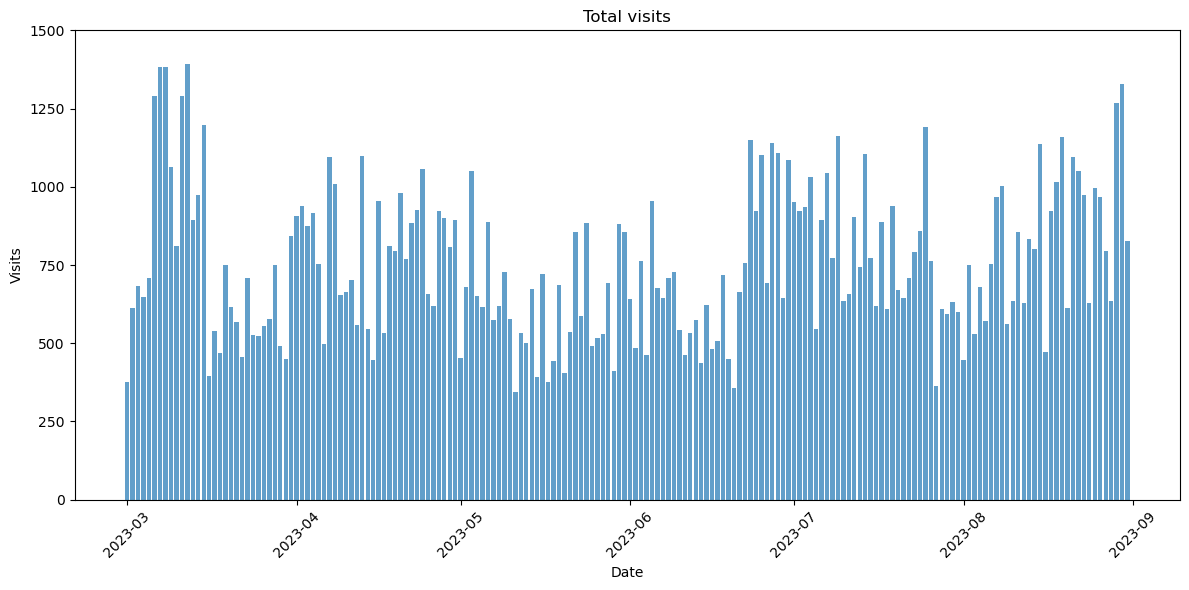

<Figure size 1200x600 with 0 Axes>

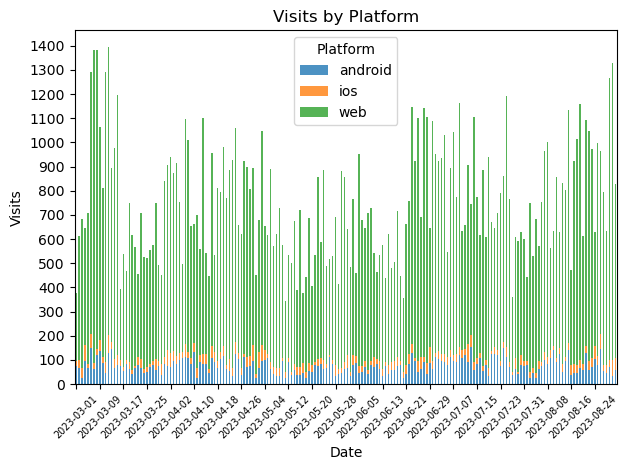

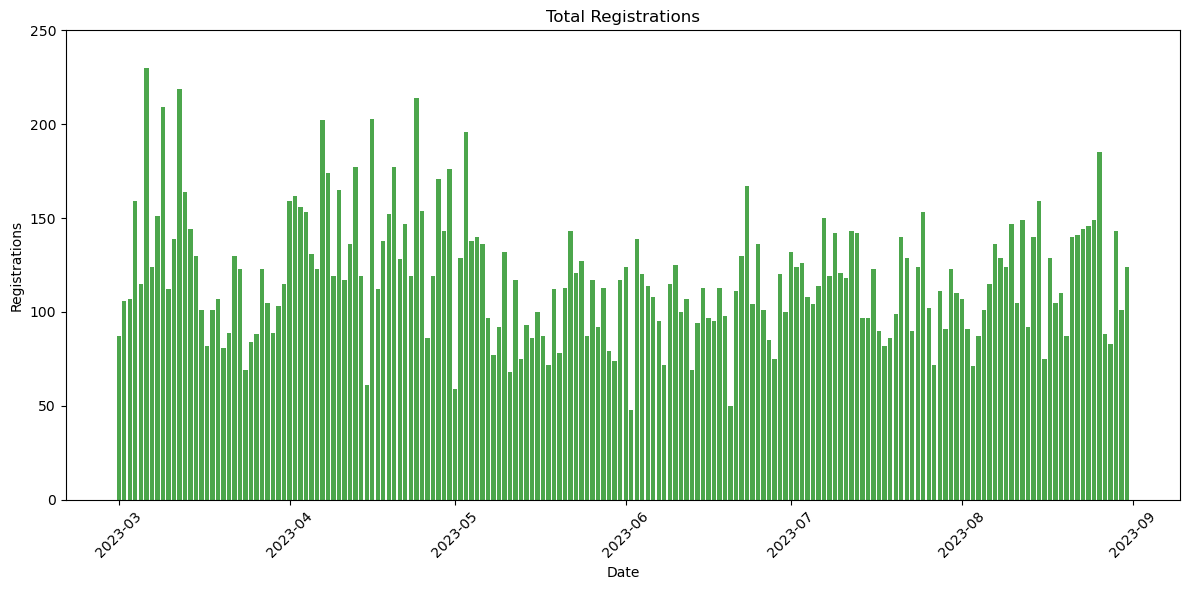

<Figure size 1200x600 with 0 Axes>

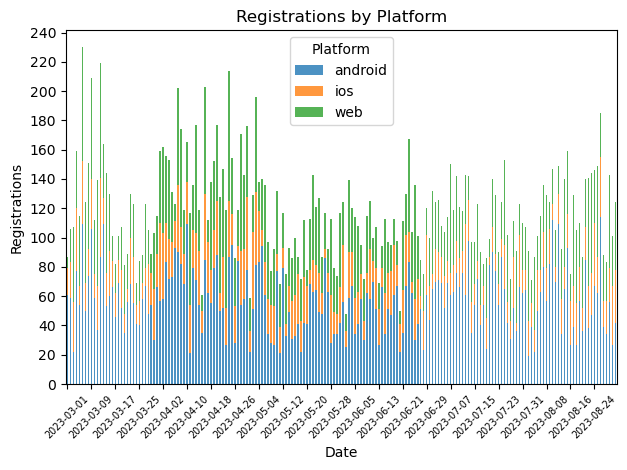

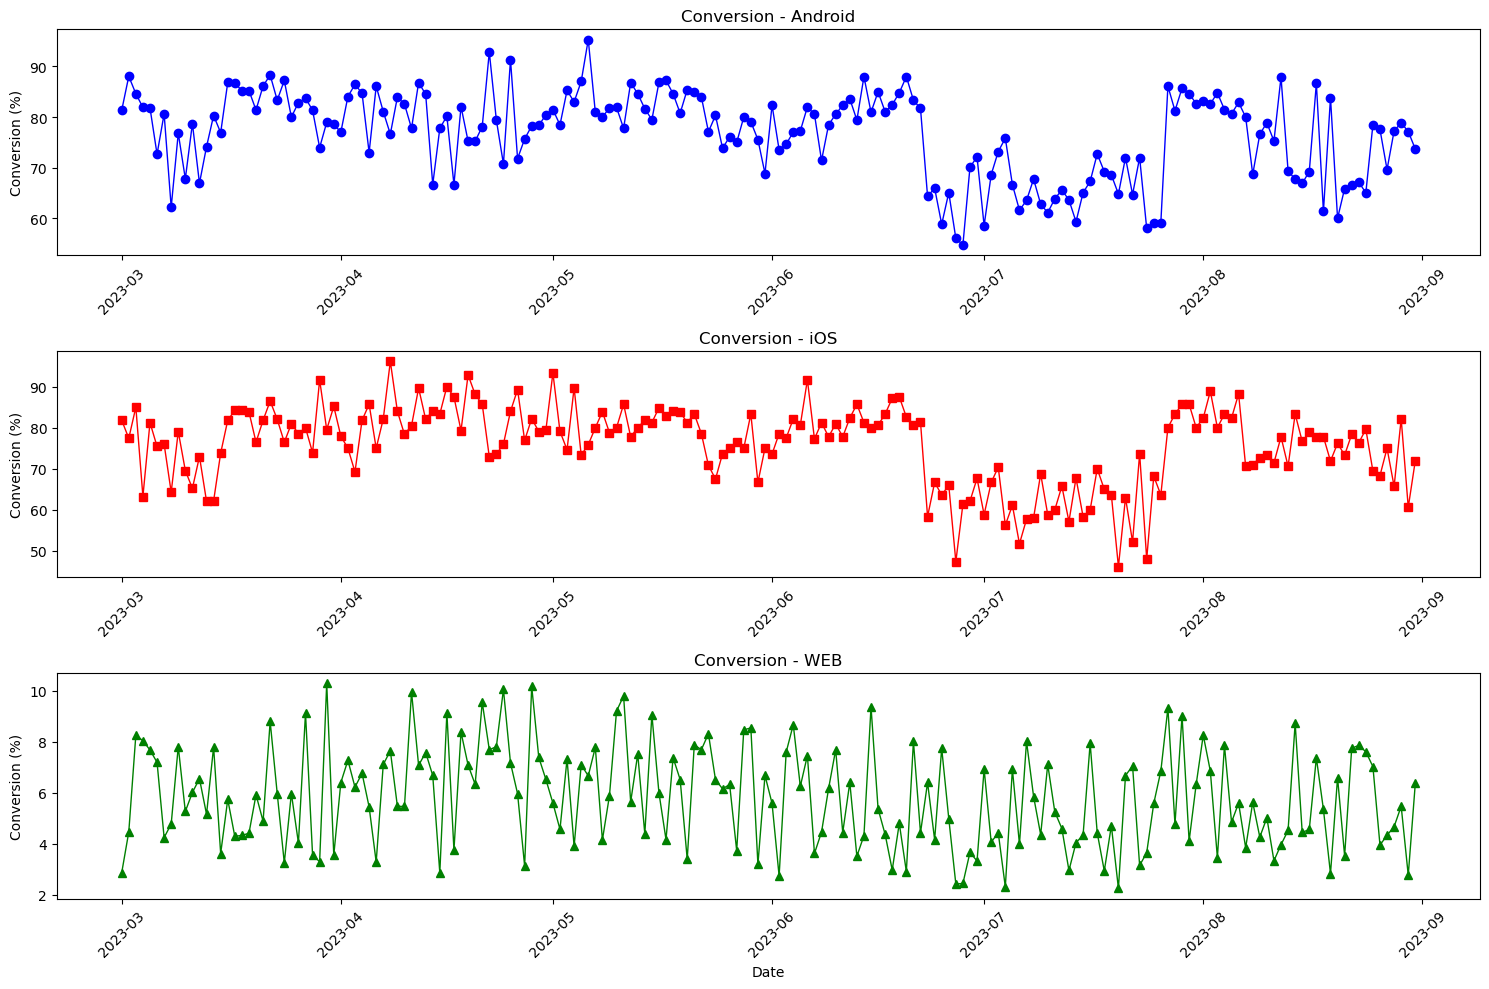

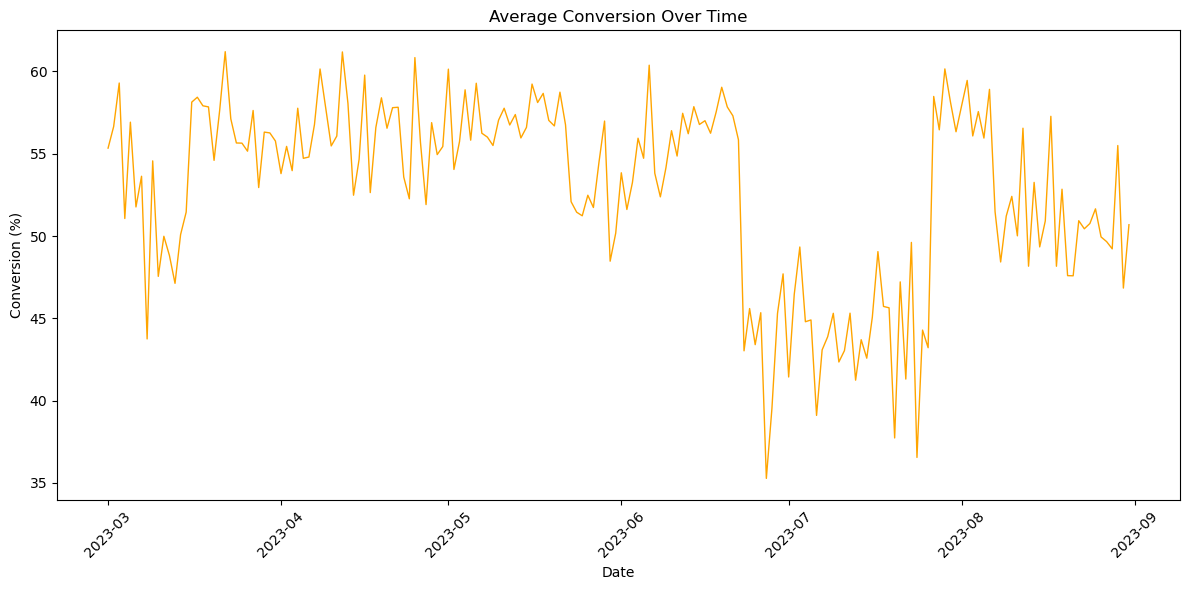

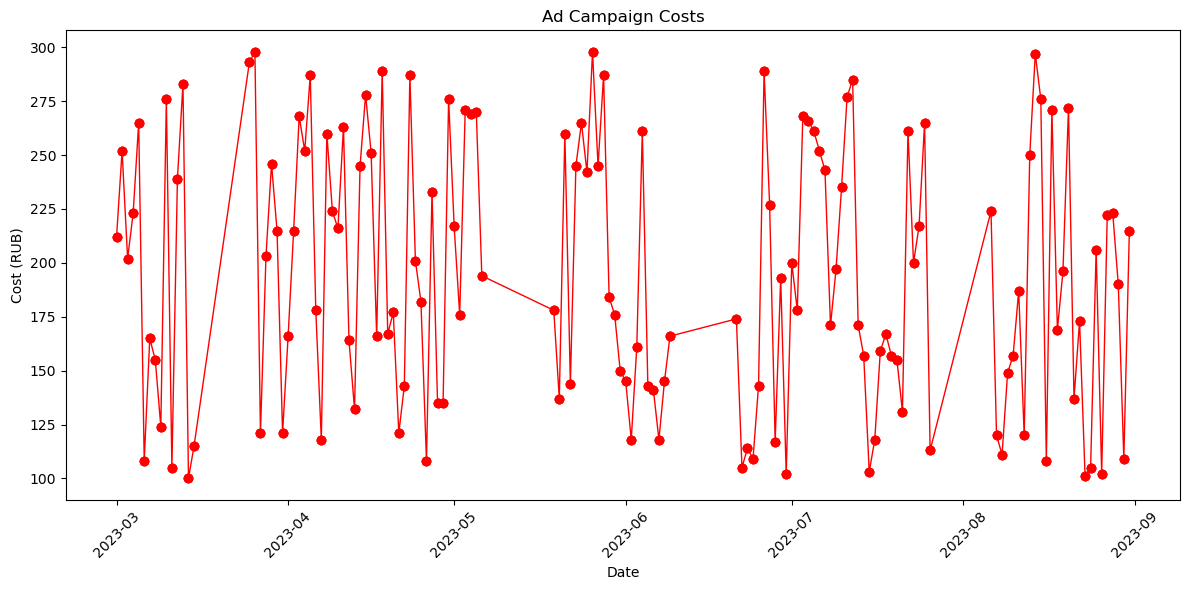

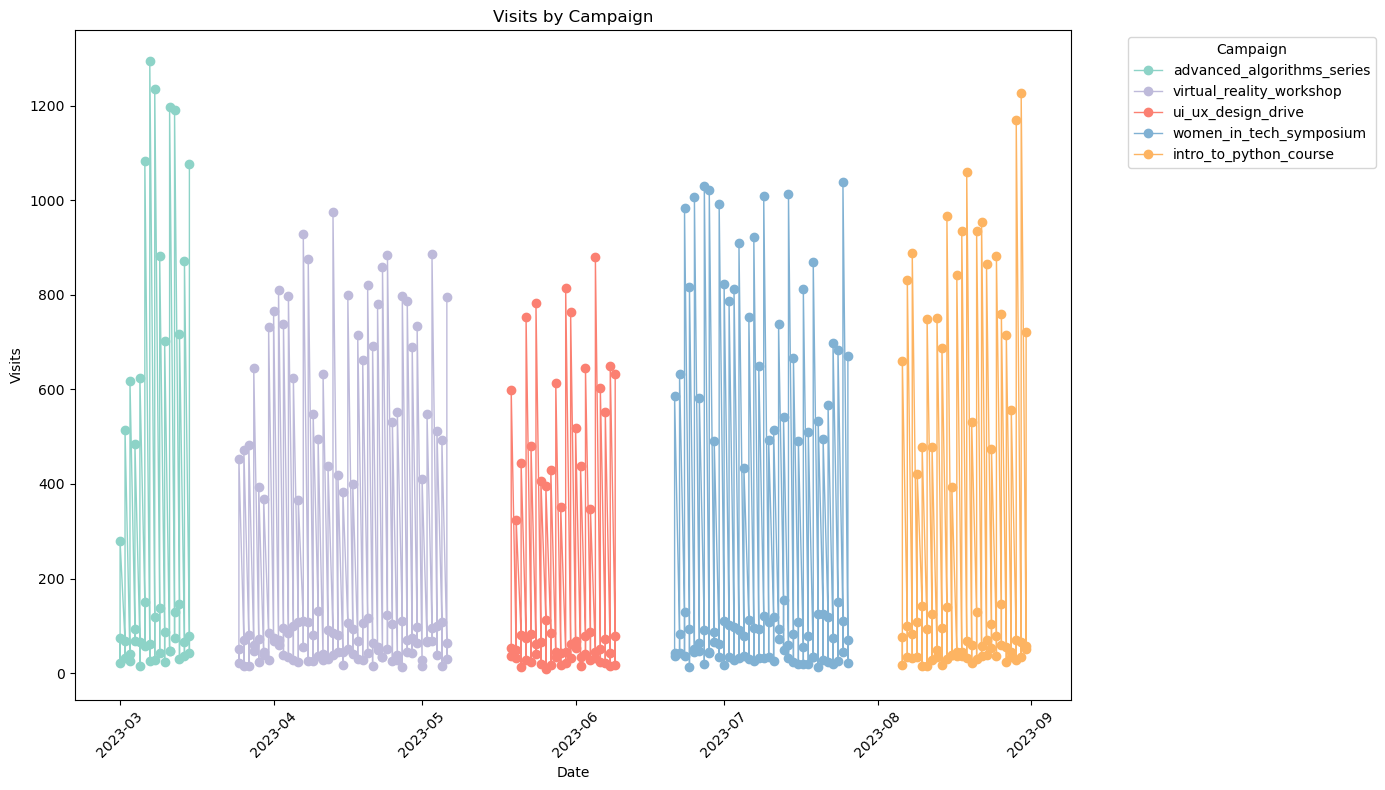

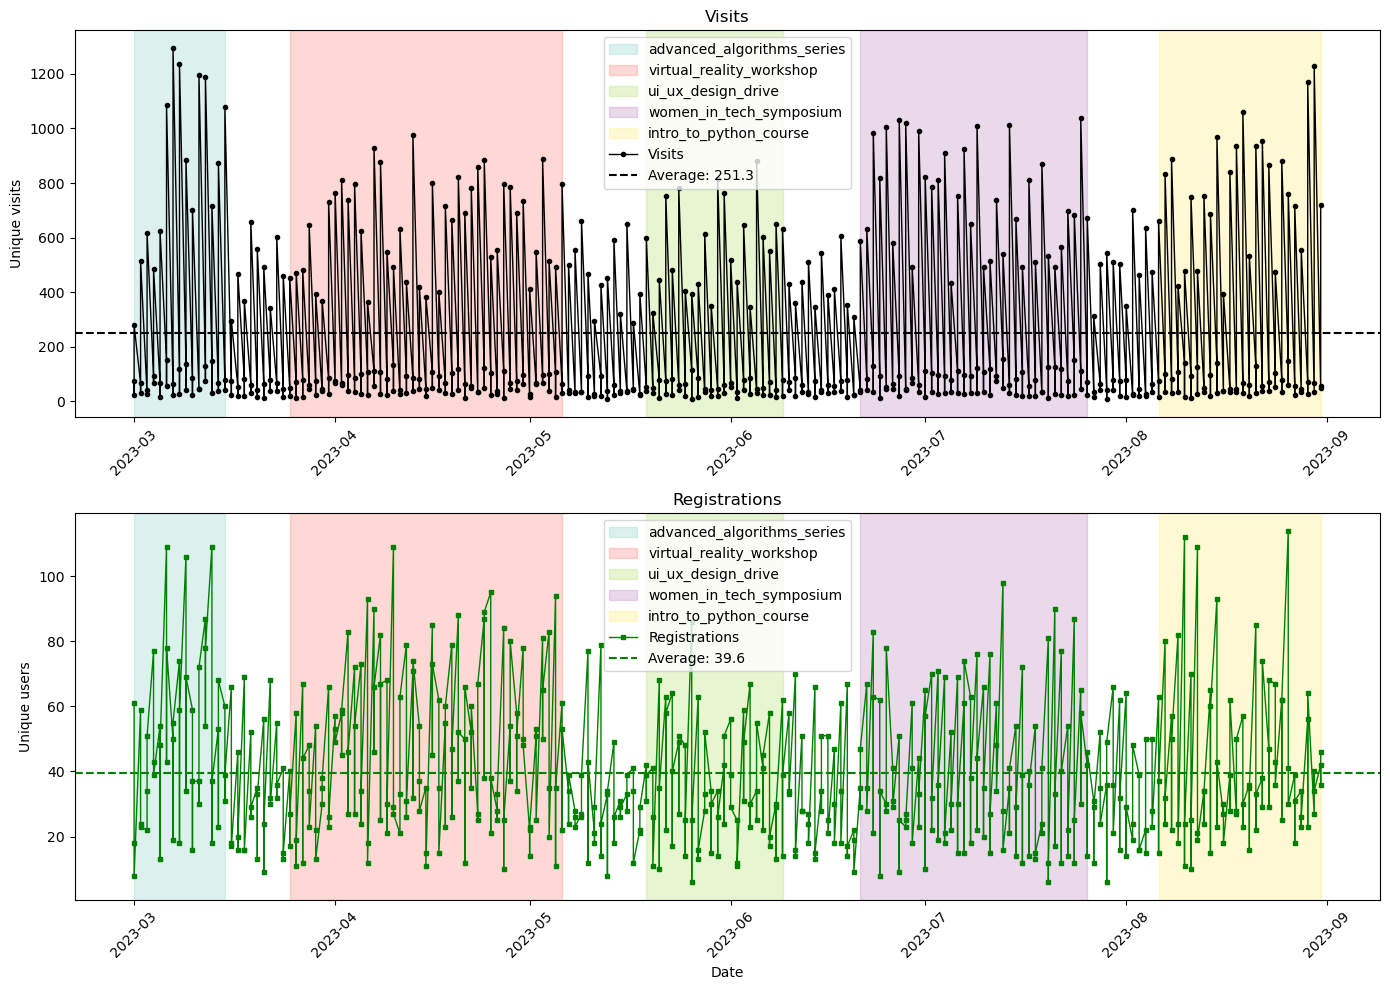

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
from datetime import datetime

# Создаем папку для визуализаций
os.makedirs('./charts', exist_ok=True)

# 1. Итоговые визиты
def plot_total_visits(cleaned_visits):
    plt.figure(figsize=(12, 6))
    visits_by_date = cleaned_visits.groupby('date_group')['visits'].sum()
    plt.bar(visits_by_date.index, visits_by_date.values, alpha=0.7)
    max_y = visits_by_date.max()
    y_ticks = np.arange(0, max_y + 250, 250)
    plt.yticks(y_ticks)
    plt.title('Total visits')
    plt.xlabel('Date')
    plt.ylabel('Visits')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('./charts/Total_visits.png')
    plt.show()

# 2. Итоговые визиты с разбивкой по платформам: web, android, ios
def plot_visits_by_platform(cleaned_visits):
    plt.figure(figsize=(12, 6))
    # Группируем по дате и платформе (по дням)
    visits_by_platform = cleaned_visits.groupby(['date_group', 'platform'])['visits'].sum().unstack()
    visits_by_platform.plot(kind='bar', stacked=True, alpha=0.8)
    max_y = visits_by_platform.sum(axis=1).max()
    y_ticks = np.arange(0, max_y + 100, 100)
    plt.yticks(y_ticks)
    plt.title('Visits by Platform')
    plt.xlabel('Date')
    plt.ylabel('Visits')
    plt.legend(title='Platform')
    dates = visits_by_platform.index
    plt.xticks(range(0, len(dates), 8), dates[::8], rotation=45, fontsize=7)
    plt.tight_layout()
    plt.savefig('./charts/Visits_by_Platform.png')
    plt.show()

# 3. Итоговые регистрации
def plot_total_registrations(cleaned_registrations):
    plt.figure(figsize=(12, 6))
    registrations_by_date = cleaned_registrations.groupby('date_group')['registrations'].sum()
    plt.bar(registrations_by_date.index, registrations_by_date.values, color='green', alpha=0.7)
    max_y = registrations_by_date.max()
    y_ticks = np.arange(0, max_y + 50, 50)
    plt.yticks(y_ticks)
    plt.title('Total Registrations')
    plt.xlabel('Date')
    plt.ylabel('Registrations')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('./charts/Total_Registrations.png')
    plt.show()

# 4. Итоговые регистрации с разбивкой по платформе: web, android, ios
def plot_registrations_by_platform(cleaned_registrations):
    plt.figure(figsize=(12, 6))
    registrations_by_platform = cleaned_registrations.groupby(['date_group', 'platform'])['registrations'].sum().unstack()
    registrations_by_platform.plot(kind='bar', stacked=True, alpha=0.8)
    max_y = registrations_by_platform.sum(axis=1).max()
    y_ticks = np.arange(0, max_y + 20, 20)
    plt.yticks(y_ticks)
    plt.title('Registrations by Platform')
    plt.xlabel('Date')
    plt.ylabel('Registrations')
    plt.legend(title='Platform')
    dates = registrations_by_platform.index
    plt.xticks(range(0, len(dates), 8), dates[::8], rotation=45, fontsize=7)
    plt.tight_layout()
    plt.savefig('./charts/Registrations_by_Platform.png')
    plt.show()

# 5. Конверсия по каждой платформе
def plot_conversion_by_platform(visits_regs_conv):
    plt.figure(figsize=(15, 10))

    # Android
    plt.subplot(3, 1, 1)
    android_data = visits_regs_conv[visits_regs_conv['platform'] == 'android']
    plt.plot(android_data['date_group'], android_data['conversion'], linewidth=1, color='blue', marker='o')
    plt.title('Conversion - Android')
    plt.ylabel('Conversion (%)')
    plt.xticks(rotation=45)

    # iOS
    plt.subplot(3, 1, 2)
    ios_data = visits_regs_conv[visits_regs_conv['platform'] == 'ios']
    plt.plot(ios_data['date_group'], ios_data['conversion'], linewidth=1, color='red', marker='s')
    plt.title('Conversion - iOS')
    plt.ylabel('Conversion (%)')
    plt.xticks(rotation=45)

    # Web
    plt.subplot(3, 1, 3)
    web_data = visits_regs_conv[visits_regs_conv['platform'] == 'web']
    plt.plot(web_data['date_group'], web_data['conversion'], linewidth=1, color='green', marker='^')
    plt.title('Conversion - WEB')
    plt.xlabel('Date')
    plt.ylabel('Conversion (%)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('./charts/Conversion_by_platform.png')
    plt.show()

# 6. Средняя конверсия
def plot_average_conversion(visits_regs_conv):
    plt.figure(figsize=(12, 6))
    conversion_over_time = visits_regs_conv.groupby('date_group')['conversion'].mean()
    plt.plot(conversion_over_time.index, conversion_over_time.values, linewidth=1, color='orange')
    plt.title('Average Conversion Over Time')
    plt.xlabel('Date')
    plt.ylabel('Conversion (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('./charts/Average_Conversion.png')
    plt.show()

# 7. Стоимости рекламы
def plot_ad_campaign_costs(convers_ads):
    plt.figure(figsize=(12, 6))
    ads_with_costs = convers_ads[convers_ads['cost'] > 0]
    plt.plot(ads_with_costs['date_group'], ads_with_costs['cost'], linewidth=1, color='red', marker='o')
    plt.title('Ad Campaign Costs')
    plt.xlabel('Date')
    plt.ylabel('Cost (RUB)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('./charts/Ad_Campaign_Costs.png')
    plt.show()

# 8. Визиты за весь период с цветовым выделением рекламной кампании
def plot_visits_by_campaign(convers_ads):
    plt.figure(figsize=(14, 8))
    campaigns = convers_ads['utm_campaign'].unique()
    campaign_colors = plt.cm.Set3(range(len(campaigns)))
    color_map = {camp: campaign_colors[i] for i, camp in enumerate(campaigns)}
    color_map['none'] = 'lightgray'

    for campaign in campaigns:
        if campaign != 'none':
            campaign_data = convers_ads[convers_ads['utm_campaign'] == campaign]
            plt.plot(campaign_data['date_group'], campaign_data['visits'], 
                    linewidth=1, marker='o', label=campaign, color=color_map[campaign])

    plt.title('Visits by Campaign')
    plt.xlabel('Date')
    plt.ylabel('Visits')
    plt.xticks(rotation=45)
    plt.legend(title='Campaign', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('./charts/Visits_by_Campaign.png', bbox_inches='tight')
    plt.show()

# 9. Два графика: визиты и регистрации с выделением кампаний
def plot_visits_registrations_by_campaign(convers_ads):
    plt.figure(figsize=(14, 10))
    campaigns = [camp for camp in convers_ads['utm_campaign'].unique() if camp != 'none']
    colors = plt.cm.Set3(np.linspace(0, 1, len(campaigns)))
    color_map = {camp: colors[i] for i, camp in enumerate(campaigns)}
    # Визиты
    plt.subplot(2, 1, 1)
    
    for campaign in campaigns:
        campaign_data = convers_ads[convers_ads['utm_campaign'] == campaign]
        if len(campaign_data) > 0:
            start = campaign_data['date_group'].min()
            end = campaign_data['date_group'].max()
            plt.axvspan(start, end, alpha=0.3, color=color_map[campaign], label=campaign)

    plt.plot(convers_ads['date_group'], convers_ads['visits'], 
             color='black', linewidth=1, marker='o', markersize=3, label='Visits')  # Уменьшены linewidth и markersize

    avg_visits = convers_ads['visits'].mean()
    plt.axhline(y=avg_visits, color='black', linestyle='--', label=f'Average: {avg_visits:.1f}')

    plt.title('Visits')
    plt.ylabel('Unique visits')
    plt.xticks(rotation=45)
    plt.legend()

    # Регистрации
    plt.subplot(2, 1, 2)

    for campaign in campaigns:
        campaign_data = convers_ads[convers_ads['utm_campaign'] == campaign]
        if len(campaign_data) > 0:
            start = campaign_data['date_group'].min()
            end = campaign_data['date_group'].max()
            plt.axvspan(start, end, alpha=0.3, color=color_map[campaign], label=campaign)

    plt.plot(convers_ads['date_group'], convers_ads['registrations'], 
             color='green', linewidth=1, marker='s', markersize=3, label='Registrations')  # Уменьшены linewidth и markersize

    avg_reg = convers_ads['registrations'].mean()
    plt.axhline(y=avg_reg, color='green', linestyle='--', label=f'Average: {avg_reg:.1f}')

    plt.title('Registrations')
    plt.xlabel('Date')
    plt.ylabel('Unique users')
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.savefig('./charts/Registrations_and_Visits_by_Campaign.png')
    plt.show()

# Функция для запуска всех графиков
def create_all_charts(cleaned_visits, cleaned_registrations, visits_regs_conv, convers_ads):
    plot_total_visits(cleaned_visits)
    plot_visits_by_platform(cleaned_visits)
    plot_total_registrations(cleaned_registrations)
    plot_registrations_by_platform(cleaned_registrations)
    plot_conversion_by_platform(visits_regs_conv)
    plot_average_conversion(visits_regs_conv)
    plot_ad_campaign_costs(convers_ads)
    plot_visits_by_campaign(convers_ads)
    plot_visits_registrations_by_campaign(convers_ads)

create_all_charts(cleaned_visits, cleaned_registrations, visits_regs_conv, convers_ads)